In [1]:
import torch
import os


In [2]:
# Function to calculate the angle between two vectors
def angle_between_vectors(v1, v2):
    cos_sim = torch.nn.functional.cosine_similarity(v1, v2, dim=0)
    angle = torch.acos(cos_sim.clamp(-1, 1))  # Clamp to avoid numerical errors
    return torch.rad2deg(angle)  # Convert from radians to degrees
    return cos_sim

def angle_between_matrices(m1, m2, dim):
    m1_norm = m1 / (torch.norm(m1, dim=dim, keepdim=True) + 1e-8)
    m2_norm = m2 / (torch.norm(m2, dim=dim, keepdim=True) + 1e-8)

    if dim == 0:
        tmp = m1_norm.T @ m2_norm
    elif dim == 1:
        tmp = m1_norm @ m2_norm.T
    cos_sim = (tmp ** 2).sum()
    return cos_sim



In [19]:
ref_dir = '/home/ardo0115/workspace/Subspace-Tuning/CR_MR/finetune/lora_r=16_epoch2'
moving_dir = '/home/ardo0115/workspace/Subspace-Tuning/CR_MR/finetune/math_lora_r=16'
ABzero_dir = '/home/ardo0115/workspace/Subspace-Tuning/CR_MR/finetune/ABzero_transformed_from-math-to-Numerical_epoch2'
Bzero_dir = '/home/ardo0115/workspace/Subspace-Tuning/CR_MR/finetune/Rank16_InitId_BzeroCossim_transformed_from-math-to-Numerical'
Bzero_Sched_dir = '/home/ardo0115/workspace/Subspace-Tuning/CR_MR/finetune/Rank16_Sched_InitId_BzeroCossimNorm1_transformed_from-math-to-Numerical_epoch2'
ABclose_dir = '/home/ardo0115/workspace/Subspace-Tuning/CR_MR/finetune/ABclose_transformed_from-math-to-Numerical_epoch2'

ref_lora = torch.load(os.path.join(ref_dir, 'adapter_model.bin'), map_location='cpu')
moving_lora = torch.load(os.path.join(moving_dir, 'adapter_model.bin'), map_location='cpu')
ABzero_lora = torch.load(os.path.join(ABzero_dir, 'adapter_model.bin'), map_location='cpu')
Bzero_lora = torch.load(os.path.join(Bzero_dir, 'adapter_model.bin'), map_location='cpu')
Bzero_Sched_lora = torch.load(os.path.join(Bzero_Sched_dir, 'adapter_model.bin'), map_location='cpu')
ABclose_lora = torch.load(os.path.join(ABclose_dir, 'adapter_model.bin'), map_location='cpu')

/tmp/ipykernel_29682/1368898088.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ref_lora = torch.load(os.path.join(ref_dir, 'adapter_model.bin'), map_location='cpu')
/tm

In [ ]:
for key in moving_lora:
    if 'lora_B' in key:
        print("moving_lora B norm:\n ", torch.norm(moving_lora[key], dim=0))
        print("Bzero B norm: \n", torch.norm(Bzero_lora[key], dim=0))
        print("moving_lora A norm: \n", torch.norm(moving_lora[key.replace('lora_B', 'lora_A')], dim=1))
        print("Bzero A norm: \n", torch.norm(Bzero_lora[key.replace('lora_B', 'lora_A')], dim=1))

        break

In [22]:
def norm_between_matrices(m1, m2, dim):
    # norm_diff = ((m1.norm(dim=dim) - m2.norm(dim=dim)) ** 2).sum()
    norm_diff = ((m1.norm(dim=dim)) ** 2).sum()

    return norm_diff
# Initialize lists to store mean angles and norms for each key containing 'lora_B'
mean_angles_moving = []
mean_angles_ABzero = []
mean_angles_Bzero = []
mean_angles_Bzero_Sched = []
mean_angles_ABclose = []

mean_norms_moving = []
mean_norms_ABzero = []
mean_norms_Bzero = []
mean_norms_Bzero_Sched = []
mean_norms_ABclose = []

for key in ref_lora.keys():
    if 'lora_B' in key:
        
        # Calculate norms for moving, ABzero, and Bzero and store their means
        norm_moving = norm_between_matrices(moving_lora[key], ref_lora[key], dim=0)
        norm_Bzero = norm_between_matrices(Bzero_lora[key], ref_lora[key], dim=0)
        norm_Bzero_Sched = norm_between_matrices(Bzero_Sched_lora[key], ref_lora[key], dim=0)

        mean_norms_moving.append(norm_moving)
        mean_norms_Bzero.append(norm_Bzero)
        mean_norms_Bzero_Sched.append(norm_Bzero_Sched)

        # Calculate angles and mean angle for moving_lora
        # angles_moving = [angle_between_vectors(moving_lora[key][:, i], ref_lora[key][:, i]) for i in range(8)]
        angles_moving = [angle_between_matrices(moving_lora[key], ref_lora[key], dim=0)]
        mean_angle_moving = torch.mean(torch.tensor(angles_moving))
        mean_angles_moving.append(mean_angle_moving)

        # Calculate angles and mean angle for ABzero_lora
        # angles_ABzero = [angle_between_vectors(ABzero_lora[key][:, i], ref_lora[key][:, i]) for i in range(8)]
        # mean_angle_ABzero = torch.mean(torch.tensor(angles_ABzero))
        # mean_angles_ABzero.append(mean_angle_ABzero)

        # Calculate angles and mean angle for Bzero_lora
        # angles_Bzero = [angle_between_vectors(Bzero_lora[key][:, i], ref_lora[key][:, i]) for i in range(8)]
        angles_Bzero = [angle_between_matrices(Bzero_lora[key], ref_lora[key], dim=0)]
        mean_angle_Bzero = torch.mean(torch.tensor(angles_Bzero))
        mean_angles_Bzero.append(mean_angle_Bzero)

        # Calculate angles and mean angle for Bzero_Sched_lora
        # angles_Bzero_Sched = [angle_between_vectors(Bzero_Sched_lora[key][:, i], ref_lora[key][:, i]) for i in range(8)]
        angles_Bzero_Sched = [angle_between_matrices(Bzero_Sched_lora[key], ref_lora[key], dim=0)]
        mean_angle_Bzero_Sched = torch.mean(torch.tensor(angles_Bzero_Sched))
        mean_angles_Bzero_Sched.append(mean_angle_Bzero_Sched)


        # # Calculate angles and mean angle for ABclose_lora
        # angles_ABclose = [angle_between_vectors(ABclose_lora[key][:, i], ref_lora[key][:, i]) for i in range(8)]
        # mean_angle_ABclose = torch.mean(torch.tensor(angles_ABclose))
        # mean_angles_ABclose.append(mean_angle_ABclose)


# Calculate the overall mean angles and norms across all keys for each type
overall_mean_angle_moving = torch.mean(torch.tensor(mean_angles_moving))
overall_mean_angle_ABzero = torch.mean(torch.tensor(mean_angles_ABzero))
overall_mean_angle_Bzero = torch.mean(torch.tensor(mean_angles_Bzero))
overall_mean_angle_Bzero_Sched = torch.mean(torch.tensor(mean_angles_Bzero_Sched))
overall_mean_angle_ABclose = torch.mean(torch.tensor(mean_angles_ABclose))

overall_mean_norm_moving = torch.mean(torch.tensor(mean_norms_moving))
overall_mean_norm_ABzero = torch.mean(torch.tensor(mean_norms_ABzero))
overall_mean_norm_Bzero = torch.mean(torch.tensor(mean_norms_Bzero))
overall_mean_norm_Bzero_Sched = torch.mean(torch.tensor(mean_norms_Bzero_Sched))
overall_mean_norm_ABclose = torch.mean(torch.tensor(mean_norms_ABclose))

print("\nOverall Mean Angle Moving:", overall_mean_angle_moving)
print("Overall Mean Angle ABzero:", overall_mean_angle_ABzero)
print("Overall Mean Angle Bzero:", overall_mean_angle_Bzero)
print("Overall Mean Angle Bzero_Sched:", overall_mean_angle_Bzero_Sched)
print("Overall Mean Angle ABclose:", overall_mean_angle_ABclose)

print("\nOverall Mean Norm Moving:", overall_mean_norm_moving)
print("Overall Mean Norm ABzero:", overall_mean_norm_ABzero)
print("Overall Mean Norm Bzero:", overall_mean_norm_Bzero)
print("Overall Mean Norm Bzero_Sched:", overall_mean_norm_Bzero_Sched)
print("Overall Mean Norm ABclose:", overall_mean_norm_ABclose)


# Calculate standard deviations
std_angles_moving = torch.std(torch.tensor(mean_angles_moving))
std_angles_ABzero = torch.std(torch.tensor(mean_angles_ABzero))
std_angles_Bzero = torch.std(torch.tensor(mean_angles_Bzero))
std_angles_ABclose = torch.std(torch.tensor(mean_angles_ABclose))

std_norms_moving = torch.std(torch.tensor(mean_norms_moving))
std_norms_ABzero = torch.std(torch.tensor(mean_norms_ABzero))



Overall Mean Angle Moving: tensor(0.3899)
Overall Mean Angle ABzero: tensor(nan)
Overall Mean Angle Bzero: tensor(0.2180)
Overall Mean Angle Bzero_Sched: tensor(0.0044)
Overall Mean Angle ABclose: tensor(nan)

Overall Mean Norm Moving: tensor(4.4126)
Overall Mean Norm ABzero: tensor(nan)
Overall Mean Norm Bzero: tensor(5.7450)
Overall Mean Norm Bzero_Sched: tensor(16.0000)
Overall Mean Norm ABclose: tensor(nan)


/tmp/ipykernel_29682/3715262058.py:89: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1808.)
  std_angles_ABzero = torch.std(torch.tensor(mean_angles_ABzero))
/tmp/ipykernel_29682/3715262058.py:91: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1808.)
  std_angles_ABclose = torch.std(torch.tensor(mean_angles_ABclose))
/tmp/ipykernel_29682/3715262058.py:94: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1808.)
  std_norms_ABzero = torch.std(torch.tensor(mean_norms_ABzero))


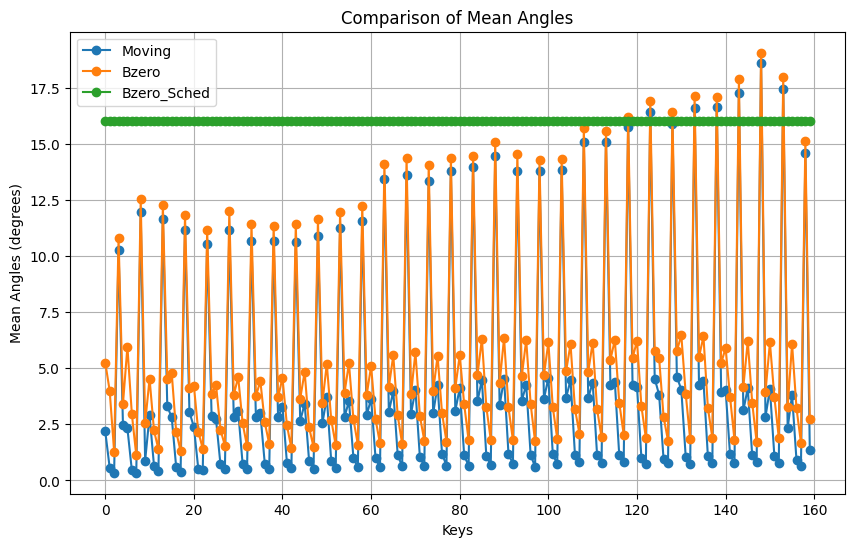

In [23]:
import matplotlib.pyplot as plt

# Define x-axis values (keys or indices)
keys = range(len(mean_angles_moving))

# Plotting mean angles
plt.figure(figsize=(10, 6))
plt.plot(keys, mean_norms_moving, label="Moving", marker='o')
plt.plot(keys, mean_norms_Bzero, label="Bzero", marker='o')
plt.plot(keys, mean_norms_Bzero_Sched, label="Bzero_Sched", marker='o')
# plot difference between moving and Bzero
# plt.plot(keys, torch.tensor(mean_angles_moving) - torch.tensor(mean_angles_Bzero), label="Moving - Bzero", marker='o')
# plt.plot(keys, torch.tensor(mean_norms_moving) - torch.tensor(mean_norms_Bzero_Sched), label="Moving - Bzero_Sched", marker='o')

plt.xlabel("Keys")
plt.ylabel("Mean Angles (degrees)")
plt.title("Comparison of Mean Angles")
plt.legend()
plt.grid(True)
plt.show()

In [7]:
def get_transformed_weights(ref_t, moving_t, lr=1e-3, num_warmup_steps=1000, num_training_steps=10000, ignore_params=[]):
    torch.manual_seed(0)
    torch.cuda.manual_seed(0)
    torch.cuda.manual_seed_all(0)
    to_optimize = {}
    for n, p in ref_t.items():
        ref_t[n] = p.cuda()
        moving_t[n] = moving_t[n].cuda()

    for n_ref,p_ref in tqdm(ref_t.items()):
        if 'lora_B' in n_ref:
            continue
        n_A = n_ref
        n_B = n_ref.replace('lora_B', 'lora_B')

        P = torch.eye(p_ref.shape[0]).cuda()
        P.requires_grad = True
        to_optimize[n_A] = {'P': P}
    
    optimizer  = torch.optim.Adam([to_optimize[n]['P'] for n in to_optimize], lr=lr)
    scheduler = transformers.get_cosine_with_hard_restarts_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps, num_cycles=1)
    loss_history = []

    for _ in tqdm(range(num_training_steps)):
        optimizer.zero_grad()
        loss = 0
        for n_A in to_optimize:
            n_B = n_A.replace('lora_B', 'lora_B')
            P = to_optimize[n_A]['P']
            B1 = ref_t[n_B]
            B2 = moving_t[n_B]
            A1 = ref_t[n_A]
            A2 = moving_t[n_A]

            loss += torch.norm(B1.t() @ B2 @ torch.inverse(P))**2
            loss += torch.norm(A1 @ (P @ A2).t())**2
        loss.backward()
        optimizer.step()
        scheduler.step()
        loss_history.append(loss.item())
    

    for n_A in to_optimize:
        if 'lora_B' in n:
            continue
        P = to_optimize[n_A]['P']
        moving_t[n_A] = P @ moving_t[n_A]
        moving_t[n_B] = moving_t[n_B] @ torch.inverse(P)
    
    return moving_t, loss_history

    
        

In [8]:
moved_st, loss_history = get_transformed_weights(ref_lora, moving_lora, lr=1e-2, num_warmup_steps=100, num_training_steps=1000)

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [ ]:
plt.plot(loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss History')
plt.savefig('loss_history_ortho2.png')